In [48]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/3-90+_DaysPastDue/data")

train = pd.read_csv("train.csv", na_values=["", "NA"])

test = pd.read_csv("test.csv", na_values=["", "NA"])


import warnings
warnings.filterwarnings('ignore')


In [49]:
lower_bound = train['feature_3'].quantile(0.01)
upper_bound = train['feature_3'].quantile(0.99)

train = train[(train['feature_3'] >= lower_bound) & (train['feature_3'] <= upper_bound)]

In [50]:
train_median = train['feature_3'].median()
train['feature_3'].fillna(train_median, inplace=True)

test_median = test['feature_3'].median()
test['feature_3'].fillna(test_median, inplace=True)

In [51]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])
    df['feature_2'] = df['feature_2'].fillna(method='ffill')
    df['feature_2'] = df['feature_2'].fillna(method='bfill')
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

In [52]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.fit_transform(train[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
test[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.transform(test[['feature_1', 'feature_2', 'feature_3', 'feature_4']])

In [54]:
train['feature_1_x_feature_2'] = train['feature_1'] * train['feature_2']
test['feature_1_x_feature_2'] = test['feature_1'] * test['feature_2']

train['feature_1_x_feature_3'] = train['feature_1'] * train['feature_3']
test['feature_1_x_feature_3'] = test['feature_1'] * test['feature_3']

train['feature_1_x_feature_4'] = train['feature_1'] * train['feature_4']
test['feature_1_x_feature_4'] = test['feature_1'] * test['feature_4']

train['feature_2_x_feature_3'] = train['feature_2'] * train['feature_3']
test['feature_2_x_feature_3'] = test['feature_2'] * test['feature_3']

train['feature_2_x_feature_4'] = train['feature_2'] * train['feature_4']
test['feature_2_x_feature_4'] = test['feature_2'] * test['feature_4']

train['feature_3_x_feature_4'] = train['feature_3'] * train['feature_4']
test['feature_3_x_feature_4'] = test['feature_3'] * test['feature_4']

In [55]:
print("\nTrain Data:")
print(f"Total rows: {len(train)}")
print(f"Number of defaults (y=1): {(train['y']==1).sum()}")
print(f"Default rate: {(train['y']==1).mean():.2%}")

print("\nTest Data:")
print(f"Total rows: {len(test)}")
print(f"Number of defaults (y=1): {(test['y']==1).sum()}")
print(f"Default rate: {(test['y']==1).mean():.2%}")

common_ids = set(train['id']) & set(test['id'])
print(f"\nNumber of overlapping IDs between train and test: {len(common_ids)}")
if len(common_ids) > 0:
    print("\nOverlapping IDs:")
    print(common_ids)



Train Data:
Total rows: 3727
Number of defaults (y=1): 782
Default rate: 20.98%

Test Data:
Total rows: 1059
Number of defaults (y=1): 214
Default rate: 20.21%

Number of overlapping IDs between train and test: 0


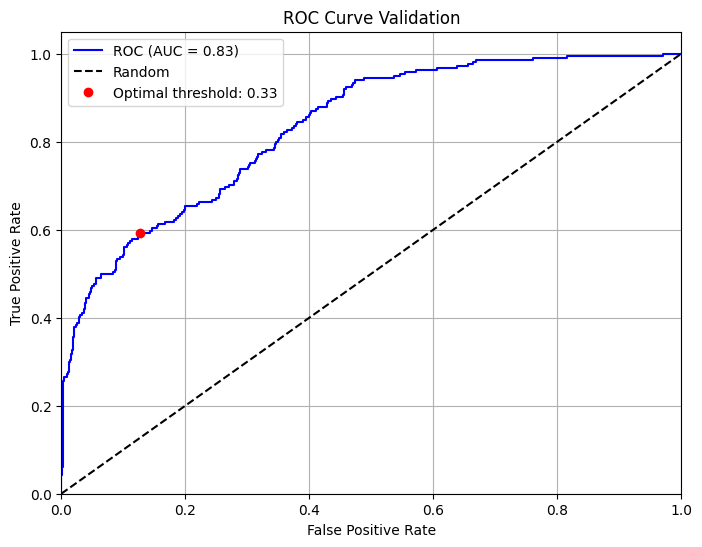

Optimal threshold: 0.334
Final test recall at optimal threshold: 0.593

Confusion Matrix:
[[738 107]
 [ 87 127]]

Test observations with predicted probabilities:
      feature_1  feature_2  feature_3  feature_4     id  date  y  \
0     -0.207033  -1.075158  -0.081758   1.090235  50821  2000  0   
1     -0.265133  -0.382683  -0.214287  -0.329658  50821  2001  0   
2     -0.583137  -0.979045  -0.387108  -0.684763  50821  2002  0   
3      0.412726   0.938019   0.102004  -0.277509  50821  2003  0   
4     -0.384059  -1.554088  -0.141369   1.385930  50821  2004  0   
...         ...        ...        ...        ...    ...   ... ..   
1054   4.826724   1.497930   0.229161  -0.881348  50901  2000  0   
1055  -0.221668  -0.406563  -0.180591  -0.146282  50901  2001  0   
1056   0.047032  -0.576580   0.062642   1.459979  50901  2002  0   
1057  -0.099301   0.005305  -0.152984  -0.533623  50901  2003  0   
1058   0.098486   0.482931   0.006547   0.393729  50901  2004  0   

      feature_1_x_fea

In [56]:
from statsmodels.api import GLM, families
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, recall_score, confusion_matrix
import matplotlib.pyplot as plt

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
interaction_cols = ['feature_1_x_feature_2', 'feature_1_x_feature_3', 
                   'feature_2_x_feature_3', 'feature_2_x_feature_4',
                   'feature_3_x_feature_4']

X_train = train[features + interaction_cols].values
y_train = train['y'].values

model = GLM(y_train, sm.add_constant(X_train), family=families.Binomial(link=sm.families.links.logit()))
results = model.fit_regularized(alpha=0.1, L1_wt=0.5)

X_test = test[features + interaction_cols].values
y_test = test['y'].values
predictions = results.predict(sm.add_constant(X_test))

fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Validation')
plt.legend(loc='lower right')
plt.grid(True)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred = (predictions >= optimal_threshold).astype(int)
final_recall = recall_score(y_test, y_pred)

plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label=f'Optimal threshold: {optimal_threshold:.2f}')
plt.legend()
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Final test recall at optimal threshold: {final_recall:.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

test['predicted_probability'] = predictions
print("\nTest observations with predicted probabilities:")
print(test)
